# Libraries and Tools

In [1]:
from utils import *
from student_utils import *
import gurobipy as grb
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Graph Class

In [2]:
class Graph:
    def __init__(self, input_file):
        parsed_data = data_parser(read_file(input_file))
        self.data = {}
        self.input_file = input_file
        self.number_of_locations = parsed_data[0] 
        self.number_of_houses = parsed_data[1] 
        self.list_of_locations = parsed_data[2]  
        self.list_of_houses = parsed_data[3] 
        self.starting_location = parsed_data[4] 
        self.adjacency_matrix = parsed_data[5] 
        self.G, message = adjacency_matrix_to_graph(self.adjacency_matrix)
        if message:
            print(message)
        else:
            print("Successful instance of Graph class")
            
    def __arrangement_matrix(self):
        arrangement_matrix = []
        for r in range(self.number_of_locations):
            row = []
            for c in range(self.number_of_houses + 2):
                matrix_element_name = "A_" + str(r) + "_" + str(c)
                row.append(self.model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
                self.model.update()
            arrangement_matrix.append(row)
        return np.array(arrangement_matrix)
        
    def __arrangement_constraints(self):
        # Get the index number of where Soda is
        soda = self.list_of_locations.index(self.starting_location)
        # Check that we start at Soda
        self.model.addConstr(self.arrangement_matrix[soda][0] == 1)
        # Check that we end at Soda
        self.model.addConstr(self.arrangement_matrix[soda][self.number_of_houses + 1] == 1)
        # Check that each column of arrangement_matrix sums up to 1
        for c in range(len(self.arrangement_matrix[0])):
            self.model.addConstr(grb.quicksum(self.arrangement_matrix[:, c]) == 1)
            
    def __walking_matrix(self):
        walking_matrix = []
        for r in range(self.number_of_locations):
            row = []
            for c in range(self.number_of_locations):
                matrix_element_name = "W_" + str(r) + "_" + str(c)
                row.append(self.model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
                self.model.update()
            walking_matrix.append(row)
        return np.array(walking_matrix)
        
    def __walking_constraints(self):
        # Boolean array of whether or not a location is a home by index
        H = (np.array(convert_locations_to_indices(self.list_of_locations, 
                                                   self.list_of_houses)) != None).astype(int)
        # Check that each column i of walking_matrix sums up to H[i]
        for i in range(len(self.walking_matrix[0])):
            self.model.addConstr(grb.quicksum(self.walking_matrix[:, i]) == H[i])
        # Check that we matched correct homes
        for vertex in range(len(self.walking_matrix)):
            self.model.addConstr(
                grb.quicksum(self.walking_matrix[vertex, :]) == 
                grb.quicksum(self.arrangement_matrix[vertex, 1:len(self.arrangement_matrix[0]) - 1]))
            
    def __cost_function(self):
        """ Driving Cost Function """
        distances = nx.floyd_warshall_numpy(self.G)
        driving_cost_function = []
        for c in range(self.number_of_houses + 1):
            summation = []
            for i in range(self.number_of_locations):
                for j in range(self.number_of_locations):
                    summation.append(
                        grb.QuadExpr(self.arrangement_matrix[i][c] * distances.item((i, j)) * self.arrangement_matrix[j][c + 1])
                    )
                    self.model.update()
            driving_cost_function.append(grb.quicksum(summation))

        """ Walking Cost Function """
        walking_cost_function = []
        for row in range(self.number_of_locations):
            for col in range(self.number_of_locations):
                walking_cost_function.append(grb.LinExpr(self.walking_matrix[row][col] * distances.item((row, col))))
                self.model.update()

        """ Set Objective Function """
        cost_function = driving_cost_function + walking_cost_function
        self.model.setObjective(grb.quicksum(cost_function), grb.GRB.MINIMIZE)
            
    def ILP(self):
        self.model = grb.Model()
        self.arrangement_matrix = self.__arrangement_matrix()
        self.walking_matrix = self.__walking_matrix()
        self.__arrangement_constraints()
        self.__walking_constraints()
        self.__cost_function()
        self.model.optimize()
        
    def optimal_arrangement_matrix(self):
        A = []
        for v in self.model.getVars():
            if v.VarName[0] == 'A':
                A.append(v.x)
        return np.array(A).reshape((self.number_of_locations, self.number_of_houses + 2))
    
    def optimal_walking_matrix(self):
        W = []
        for v in self.model.getVars():
            if v.VarName[0] == 'W':
                W.append(v.x)
        return np.array(W).reshape((self.number_of_locations, self.number_of_locations))
        

In [3]:
#graph = Graph("inputs/84_50.in")
graph = Graph("inputs/practice.in") # Homework example
#graph = Graph("inputs/264_50.in") # Pauls Example
#graph = Graph("inputs/basic.in") # Basic Example

Successful instance of Graph class


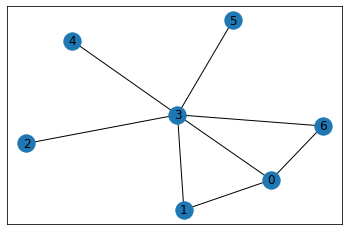

In [4]:
nx.draw_networkx(graph.G)

# Integer Linear Programming

In [5]:
graph.ILP()

Academic license - for non-commercial use only
Optimize a model with 22 rows, 91 columns and 170 nonzeros
Model has 210 quadratic objective terms
Variable types: 0 continuous, 91 integer (91 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 7 rows and 35 columns
Presolve time: 0.00s
Presolved: 141 rows, 182 columns, 490 nonzeros
Variable types: 0 continuous, 182 integer (182 binary)

Root relaxation: objective 3.000000e+00, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.00000    0    8   13.00000    3.00000  76.9%     -    0s
H    0     0                       9.0000000    3.00000  66.7%     -    0s
     0     0    3.00000   

In [ ]:
graph.optimal_arrangement_matrix()

In [ ]:
graph.optimal_walking_matrix()